# Cost Savings Analysis with Prophet Model

This notebook demonstrates how to analyze cost savings by optimizing consumption based on price predictions from a Prophet model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import logging
import os
from datetime import datetime, timedelta

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

/opt/miniconda3/envs/enexis-may-01-env-run/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cost Savings Analyzer Class

This class handles the optimization of consumption based on price predictions and calculates the resulting cost savings.

In [7]:
class CostSavingsAnalyzer:
    def __init__(self, avg_daily_consumption: float = 1000.0):
        """Initialize the analyzer with average daily consumption"""
        self.avg_daily_consumption = avg_daily_consumption
        self.logger = logging.getLogger(__name__)
    
    def optimize_consumption(self, df: pd.DataFrame) -> pd.DataFrame:
        """Optimize consumption based on predicted prices"""
        self.logger.info("Starting consumption optimization...")
        
        # Create a copy of the dataframe
        df = df.copy()
        
        # Use actual prices when predicted prices are NaN
        df['price_for_optimization'] = df['predicted_price'].fillna(df['actual_price'])
        
        # Calculate price percentiles
        price_percentiles = df['price_for_optimization'].quantile([0.33, 0.66])
        low_price_threshold = price_percentiles[0.33]
        high_price_threshold = price_percentiles[0.66]
        
        # Initialize optimized consumption
        df['optimized_consumption'] = self.avg_daily_consumption
        
        # Count days in each price category
        low_price_days = (df['price_for_optimization'] <= low_price_threshold).sum()
        high_price_days = (df['price_for_optimization'] >= high_price_threshold).sum()
        medium_price_days = len(df) - low_price_days - high_price_days
        
        # Calculate consumption adjustments
        if low_price_days > 0:
            # On low price days, consume 20% more than average
            low_price_consumption = self.avg_daily_consumption * 1.2
            df.loc[df['price_for_optimization'] <= low_price_threshold, 'optimized_consumption'] = low_price_consumption
        
        if high_price_days > 0:
            # On high price days, consume 20% less than average
            high_price_consumption = self.avg_daily_consumption * 0.8
            df.loc[df['price_for_optimization'] >= high_price_threshold, 'optimized_consumption'] = high_price_consumption
        
        # Calculate total consumption
        total_consumption = df['optimized_consumption'].sum()
        target_consumption = self.avg_daily_consumption * len(df)
        
        # Adjust consumption to match target if needed
        if total_consumption != target_consumption:
            adjustment_factor = target_consumption / total_consumption
            df['optimized_consumption'] *= adjustment_factor
        
        # Log optimization summary
        self.logger.info("\nOptimization Summary:")
        self.logger.info(f"Low price days (<= {low_price_threshold:.4f}): {low_price_days} days")
        self.logger.info(f"High price days (>= {high_price_threshold:.4f}): {high_price_days} days")
        self.logger.info(f"Medium price days: {medium_price_days} days")
        
        return df
    
    def calculate_cost_savings(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculate cost savings between actual and predicted prices"""
        self.logger.info("Starting cost savings calculation...")
        
        # Validate input DataFrame
        required_columns = ['actual_price', 'predicted_price']
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
        
        # Create a copy to avoid modifying the input
        results_df = df.copy()
        
        # Calculate costs with average consumption
        results_df['avg_consumption_cost'] = results_df['actual_price'] * self.avg_daily_consumption
        
        # Optimize consumption based on predicted prices
        results_df = self.optimize_consumption(results_df)
        
        # Calculate costs with optimized consumption
        results_df['optimized_cost'] = results_df['actual_price'] * results_df['optimized_consumption']
        
        # Calculate savings
        results_df['savings'] = results_df['avg_consumption_cost'] - results_df['optimized_cost']
        results_df['cumulative_savings'] = results_df['savings'].cumsum()
        
        # Calculate total consumption
        results_df['total_consumption'] = results_df['optimized_consumption'].sum()
        results_df['avg_consumption'] = results_df['optimized_consumption'].mean()
        
        # Log detailed analysis
        self.logger.info("\nDetailed Analysis:")
        self.logger.info("\nPrice Statistics:")
        self.logger.info(f"Mean actual price: {results_df['actual_price'].mean():.2f}")
        self.logger.info(f"Min actual price: {results_df['actual_price'].min():.2f}")
        self.logger.info(f"Max actual price: {results_df['actual_price'].max():.2f}")
        
        self.logger.info("\nConsumption Statistics:")
        self.logger.info(f"Mean optimized consumption: {results_df['optimized_consumption'].mean():.2f}")
        self.logger.info(f"Min optimized consumption: {results_df['optimized_consumption'].min():.2f}")
        self.logger.info(f"Max optimized consumption: {results_df['optimized_consumption'].max():.2f}")
        
        self.logger.info("\nCost Statistics:")
        self.logger.info(f"Total average consumption cost: {results_df['avg_consumption_cost'].sum():.2f}")
        self.logger.info(f"Total optimized cost: {results_df['optimized_cost'].sum():.2f}")
        self.logger.info(f"Total savings: {results_df['savings'].sum():.2f}")
        
        return results_df
    
    def plot_savings(self, results_df: pd.DataFrame):
        """Plot the cost savings analysis"""
        self.logger.info("Creating savings visualization...")
        
        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1])
        
        # Plot 1: Daily costs and savings
        ax1.plot(results_df['timestamp'], results_df['avg_consumption_cost'], 
                 label='Average Consumption Cost', color='blue', alpha=0.7)
        ax1.plot(results_df['timestamp'], results_df['optimized_cost'], 
                 label='Optimized Cost', color='green', alpha=0.7)
        ax1.fill_between(results_df['timestamp'], 
                         results_df['avg_consumption_cost'], 
                         results_df['optimized_cost'],
                         where=(results_df['avg_consumption_cost'] > results_df['optimized_cost']),
                         color='green', alpha=0.2, label='Savings')
        ax1.fill_between(results_df['timestamp'], 
                         results_df['avg_consumption_cost'], 
                         results_df['optimized_cost'],
                         where=(results_df['avg_consumption_cost'] <= results_df['optimized_cost']),
                         color='red', alpha=0.2, label='Losses')
        
        ax1.set_title('Daily Cost Comparison: Average vs Optimized Consumption')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Cost')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Cumulative savings
        ax2.plot(results_df['timestamp'], results_df['cumulative_savings'], 
                 label='Cumulative Savings', color='purple')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        
        ax2.set_title('Cumulative Savings Over Time')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Cumulative Savings')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Adjust layout
        plt.tight_layout()
        plt.show()

## Generate Sample Data

Let's create some sample data to demonstrate the cost savings analysis.

In [3]:
def generate_sample_data() -> pd.DataFrame:
    """Load and prepare data from the rolling predictions CSV file"""
    # Read the CSV file
    file_path = '/Users/sgawde/work/eaisi-code/main-branch-01-jun/ENEXIS/src/models/model_run_results/rolling_predictions.csv'
    df = pd.read_csv(file_path)
    
    # Rename columns to match our expected format
    df = df.rename(columns={
        'Timestamp': 'timestamp',
        'Actual': 'actual_price',
        'Predicted_1d_ahead': 'predicted_price'
    })
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Fill NaN values in predicted_price with actual_price
    df['predicted_price'] = df['predicted_price'].fillna(df['actual_price'])
    
    # Select only the required columns
    df = df[['timestamp', 'actual_price', 'predicted_price']]
    
    # Log the data summary
    print("\nData Summary:")
    print(f"Number of days: {len(df)}")
    print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print("\nPrice Statistics:")
    print(f"Actual price - Mean: {df['actual_price'].mean():.4f}, Min: {df['actual_price'].min():.4f}, Max: {df['actual_price'].max():.4f}")
    print(f"Predicted price - Mean: {df['predicted_price'].mean():.4f}, Min: {df['predicted_price'].min():.4f}, Max: {df['predicted_price'].max():.4f}")
    
    return df

# Generate sample data
sample_data = generate_sample_data()
sample_data.head()

,timestamp,actual_price,predicted_price
0,2024-01-01,0.022484,0.021280
1,2024-01-02,0.019309,0.023013
2,2024-01-03,0.023238,0.023211
3,2024-01-04,0.027615,0.025500
4,2024-01-05,0.018829,0.020474


## Run Cost Savings Analysis

Now let's run the cost savings analysis on our sample data.

In [4]:
# Initialize analyzer
analyzer = CostSavingsAnalyzer(avg_daily_consumption=1000.0)

# Calculate cost savings
results = analyzer.calculate_cost_savings(sample_data)

# Display results summary
print("\nResults Summary:")
print(f"Total Savings: {results['savings'].sum():.2f}")
print(f"Average Daily Savings: {results['savings'].mean():.2f}")
print(f"Maximum Daily Savings: {results['savings'].max():.2f}")
print(f"Minimum Daily Savings: {results['savings'].min():.2f}")

INFO:__main__:Starting cost savings calculation...
INFO:__main__:Starting consumption optimization...
INFO:__main__:
Optimization Summary:
INFO:__main__:Low price days (<= 0.0171): 10 days
INFO:__main__:High price days (>= 0.0210): 10 days
INFO:__main__:Medium price days: 10 days
INFO:__main__:
Detailed Analysis:
INFO:__main__:
Price Statistics:
INFO:__main__:Mean actual price: 0.02
INFO:__main__:Min actual price: 0.01
INFO:__main__:Max actual price: 0.03
INFO:__main__:
Consumption Statistics:
INFO:__main__:Mean optimized consumption: 1000.00
INFO:__main__:Min optimized consumption: 800.00
INFO:__main__:Max optimized consumption: 1200.00
INFO:__main__:
Cost Statistics:
INFO:__main__:Total average consumption cost: 571.78
INFO:__main__:Total optimized cost: 554.05
INFO:__main__:Total savings: 17.73



Results Summary:
Total Savings: 17.73
Average Daily Savings: 0.59
Maximum Daily Savings: 5.58
Minimum Daily Savings: -3.77


## Visualize Results

Let's visualize the cost savings analysis results.

INFO:__main__:Creating savings visualization...


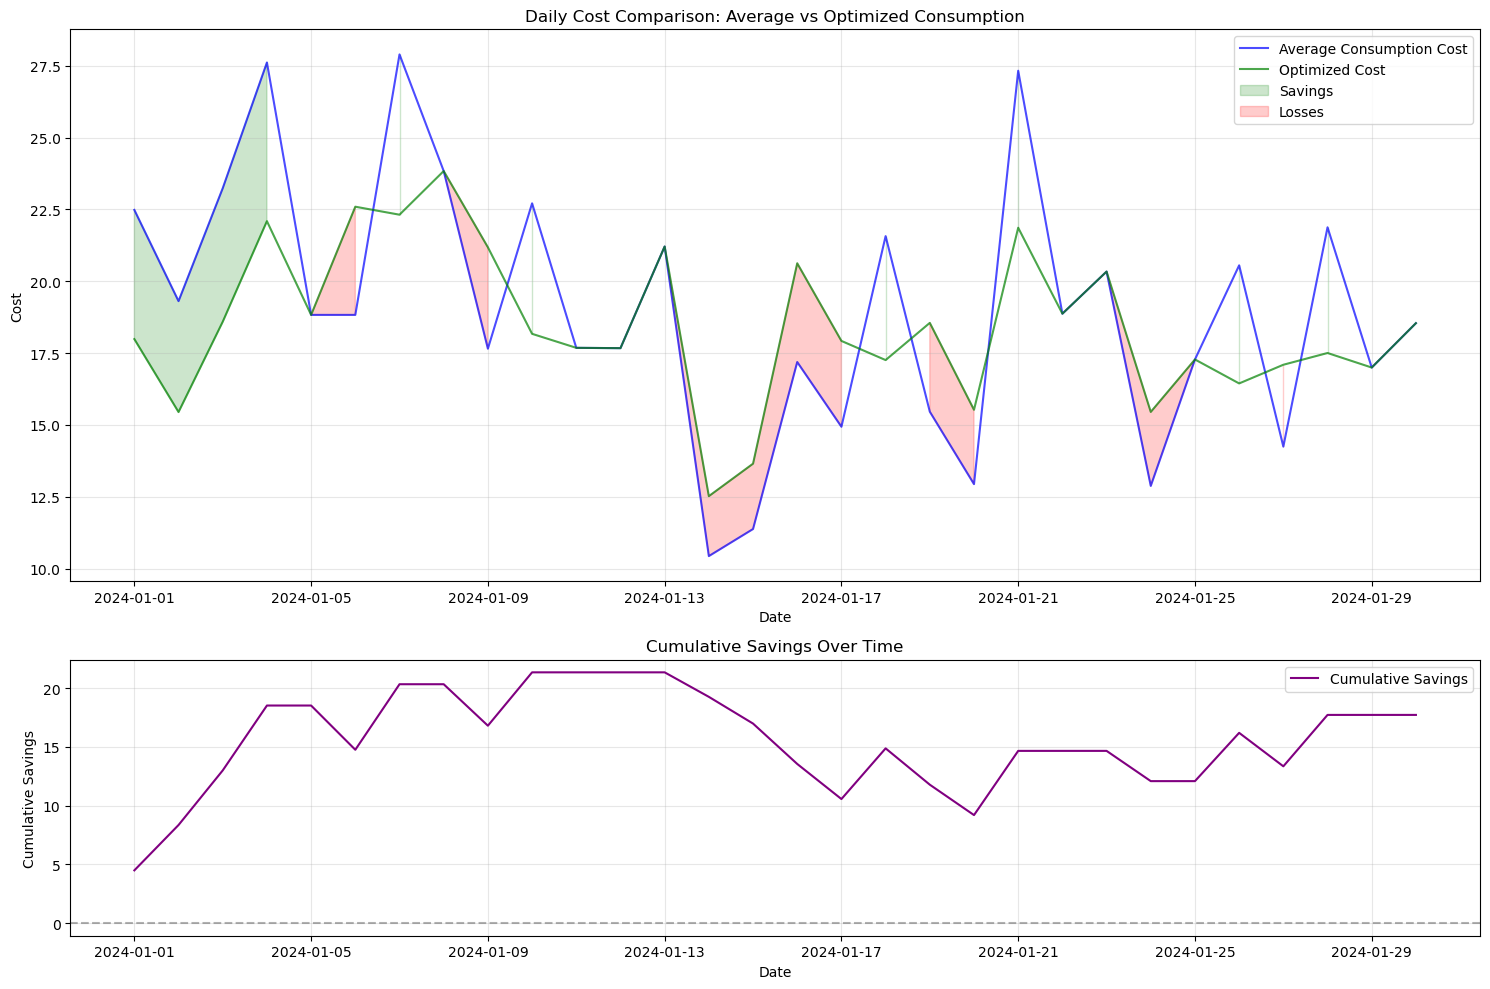

In [5]:
# Plot the results
analyzer.plot_savings(results)

## Additional Analysis

Let's add some additional analysis to understand the distribution of savings and consumption patterns.

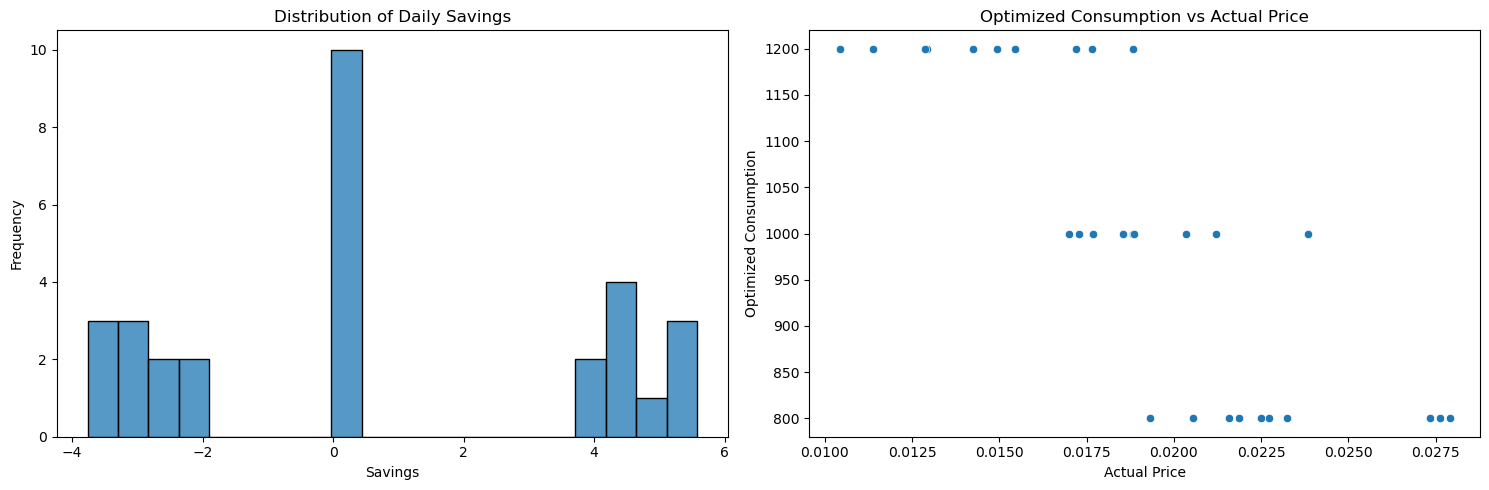

In [6]:
# Create additional visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Distribution of savings
sns.histplot(data=results, x='savings', bins=20, ax=ax1)
ax1.set_title('Distribution of Daily Savings')
ax1.set_xlabel('Savings')
ax1.set_ylabel('Frequency')

# Plot 2: Scatter plot of actual vs optimized consumption
sns.scatterplot(data=results, x='actual_price', y='optimized_consumption', ax=ax2)
ax2.set_title('Optimized Consumption vs Actual Price')
ax2.set_xlabel('Actual Price')
ax2.set_ylabel('Optimized Consumption')

plt.tight_layout()
plt.show()